In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
data = pd.read_csv('listings_summary_dec18.csv')

In [3]:
data = data.drop(["latitude","longitude","last_review","neighbourhood_group"],axis=1)

In [4]:
data.head()

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,9835,Beautiful Room & House,33057,Manju,Manningham,Private room,60,1,4,0.04,1,365
1,10803,Room in Cool Deco Apartment in Brunswick,38901,Lindsay,Moreland,Private room,35,3,108,1.50,1,213
2,12936,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,50121,Frank & Vince,Port Phillip,Entire home/apt,159,3,15,0.15,17,326
3,15246,Large private room-close to city,59786,Eleni,Darebin,Private room,50,2,29,0.30,3,0
4,16760,Melbourne BnB near City & Sports,65090,Colin,Port Phillip,Private room,69,1,63,0.74,1,328


In [5]:
data['neighbourhood'].isnull().any()

False

In [6]:
data['room_type'].isnull().any()

False

In [7]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["key_neighbourhood"] = lb_make.fit_transform(data["neighbourhood"])
data["key_room_type"] = lb_make.fit_transform(data["room_type"])

data[["neighbourhood", "key_neighbourhood","room_type","key_room_type"]].head(11)
target_key_room_type = data["key_room_type"]
target_key_neighbourhood = data["key_neighbourhood"]

In [8]:
data = data.drop(["name","host_name","neighbourhood","room_type","id","host_id","key_neighbourhood","key_room_type"],axis=1)

In [9]:
data = data.interpolate()
data.head()

,id,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,key_neighbourhood,key_room_type
0,9835,33057,60,1,4,0.04,1,365,14,1
1,10803,38901,35,3,108,1.50,1,213,21,1
2,12936,50121,159,3,15,0.15,17,326,23,0
3,15246,59786,50,2,29,0.30,3,0,6,1
4,16760,65090,69,1,63,0.74,1,328,23,1


# EDA

In [10]:
print("shape : ",data.shape)
print("colum : ",data.columns)
print("info : ",data.info())

shape :  (22895, 10)
colum :  Index(['id', 'host_id', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'key_neighbourhood', 'key_room_type'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 10 columns):
id                                22895 non-null int64
host_id                           22895 non-null int64
price                             22895 non-null int64
minimum_nights                    22895 non-null int64
number_of_reviews                 22895 non-null int64
reviews_per_month                 22895 non-null float64
calculated_host_listings_count    22895 non-null int64
availability_365                  22895 non-null int64
key_neighbourhood                 22895 non-null int64
key_room_type                     22895 non-null int64
dtypes: float64(1), int64(9)
memory usage: 1.7 MB
info :  None


In [11]:
data.describe()

,id,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,key_neighbourhood,key_room_type
count,2.289500e+04,2.289500e+04,22895.000000,22895.000000,22895.000000,22895.000000,22895.000000,22895.000000,22895.000000,22895.000000
mean,1.869883e+07,7.083412e+07,148.004368,4.059314,21.266477,1.601775,7.125792,135.147063,18.286001,0.389430
std,8.141522e+06,6.471893e+07,210.883253,25.883257,39.013606,1.629738,15.637804,133.326188,7.183858,0.522234
min,9.835000e+03,9.082000e+03,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000
25%,1.287570e+07,1.728005e+07,71.000000,1.000000,1.000000,0.380000,1.000000,4.000000,17.000000,0.000000
50%,2.026177e+07,4.801411e+07,111.000000,2.000000,5.000000,1.013333,1.000000,88.000000,17.000000,0.000000
75%,2.495525e+07,1.143842e+08,165.000000,3.000000,23.500000,2.263333,4.000000,276.000000,23.000000,1.000000
max,3.059362e+07,2.294705e+08,12624.000000,1125.000000,538.000000,14.540000,98.000000,365.000000,29.000000,2.000000


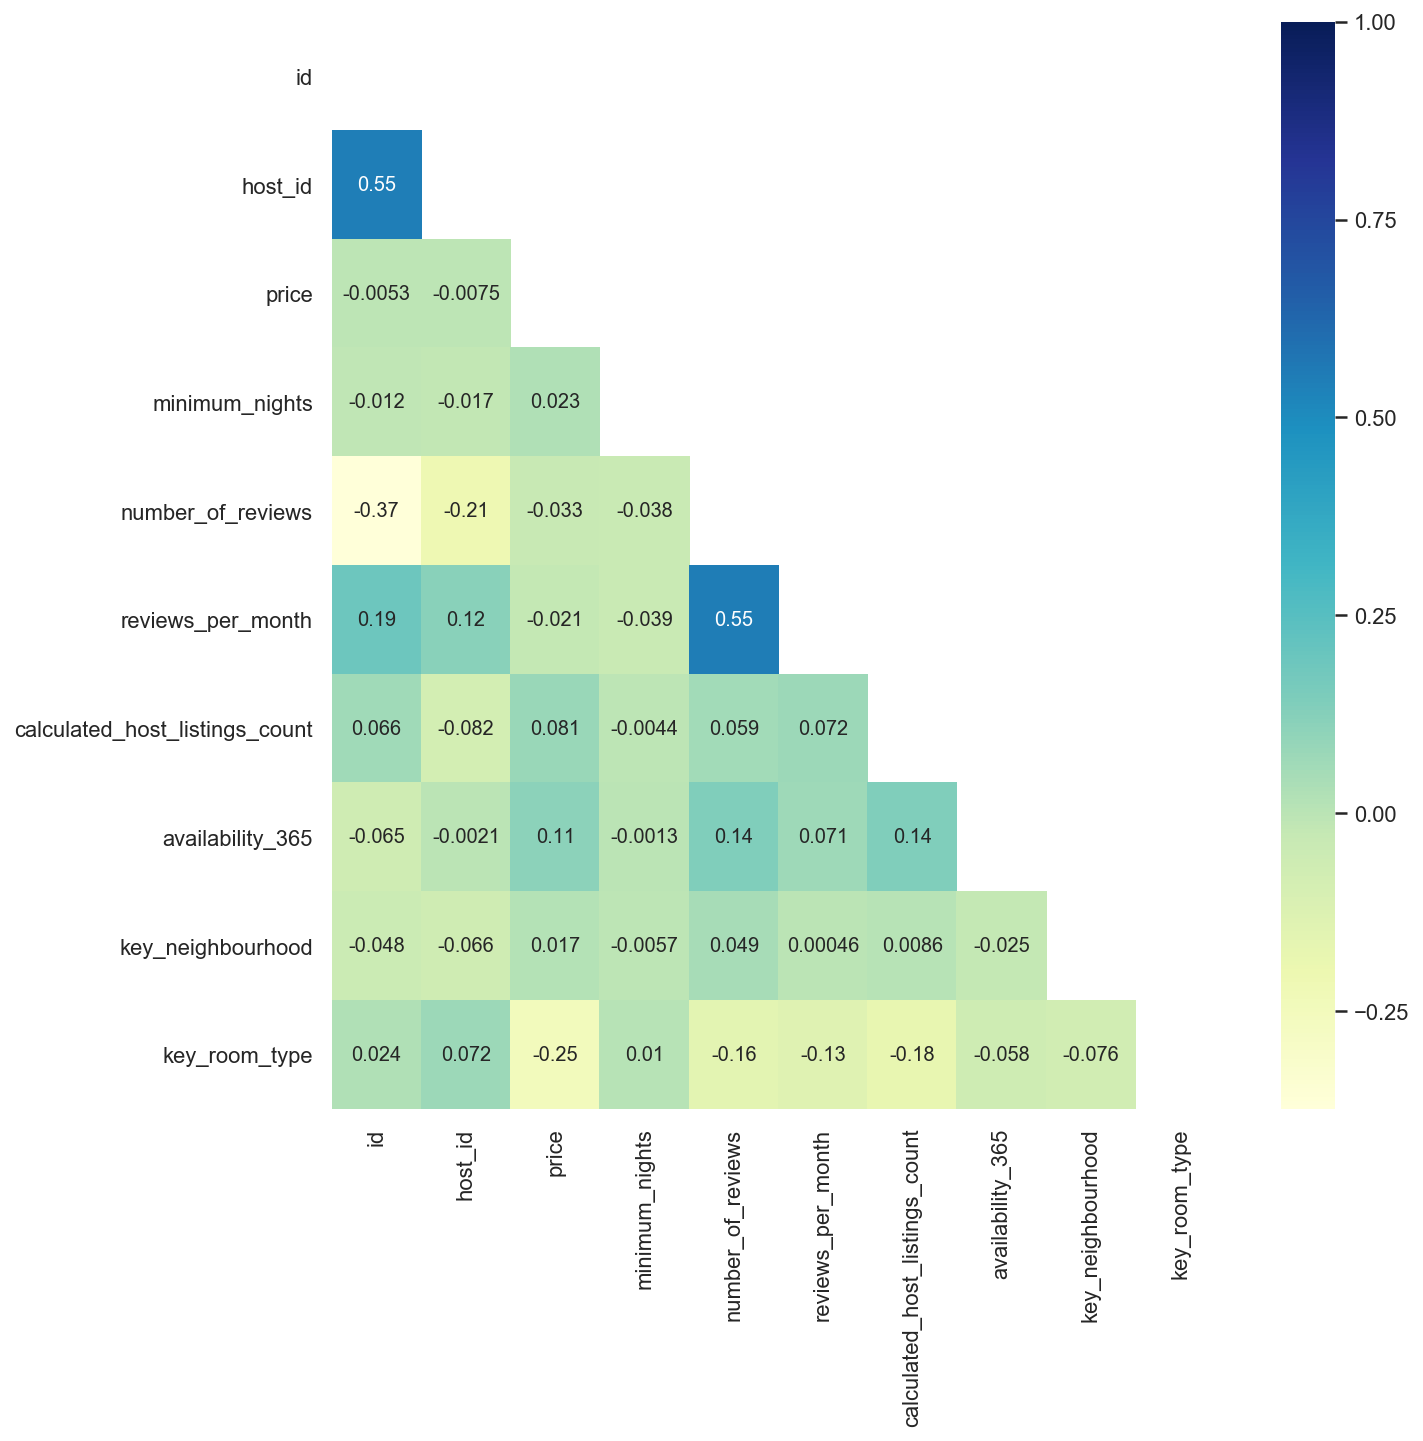

In [12]:
corr = data.corr()
plt.figure(figsize = (10,10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,mask=mask,annot=True,cmap="YlGnBu")


In [13]:
g=sns.pairplot(df,vars=df.columns[0:6],hue=df.columns[6], markers=["s","+"])

NameError: name 'df' is not defined

In [ ]:
data["price"].values

In [ ]:
from sklearn.decomposition import PCA
print(data.shape)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)
# X_pca = pca.fit_transform(data.as_matrix())
print(X_pca.shape)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA without StandardScaler')
plt.xlabel("first principal component")
plt.ylabel("second principal component")

In [ ]:
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(data)
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=target_key_room_type, alpha=.9)

plt.title('PCA with StandardScaler')
plt.xlabel("first principal component")
plt.ylabel("second principal component")